### Курсовой проект "Предсказание цен на недвижимость"<a class='anchor' id='course'>

https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/overview
     
Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 10.01.21
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 

**Описание датасета:**
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

**Импорт библиотек:**

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
pd.set_option('display.max_columns', None)

**Загрузка данных:**

In [2]:
DATASET_PATH_TRAIN = 'train.csv'
DATASET_PATH_TEST = 'test.csv'

train_df = pd.read_csv(DATASET_PATH_TRAIN, sep=',')
test_df = pd.read_csv(DATASET_PATH_TEST, sep=',')

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [3]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Исследование данных:**

In [5]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [6]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


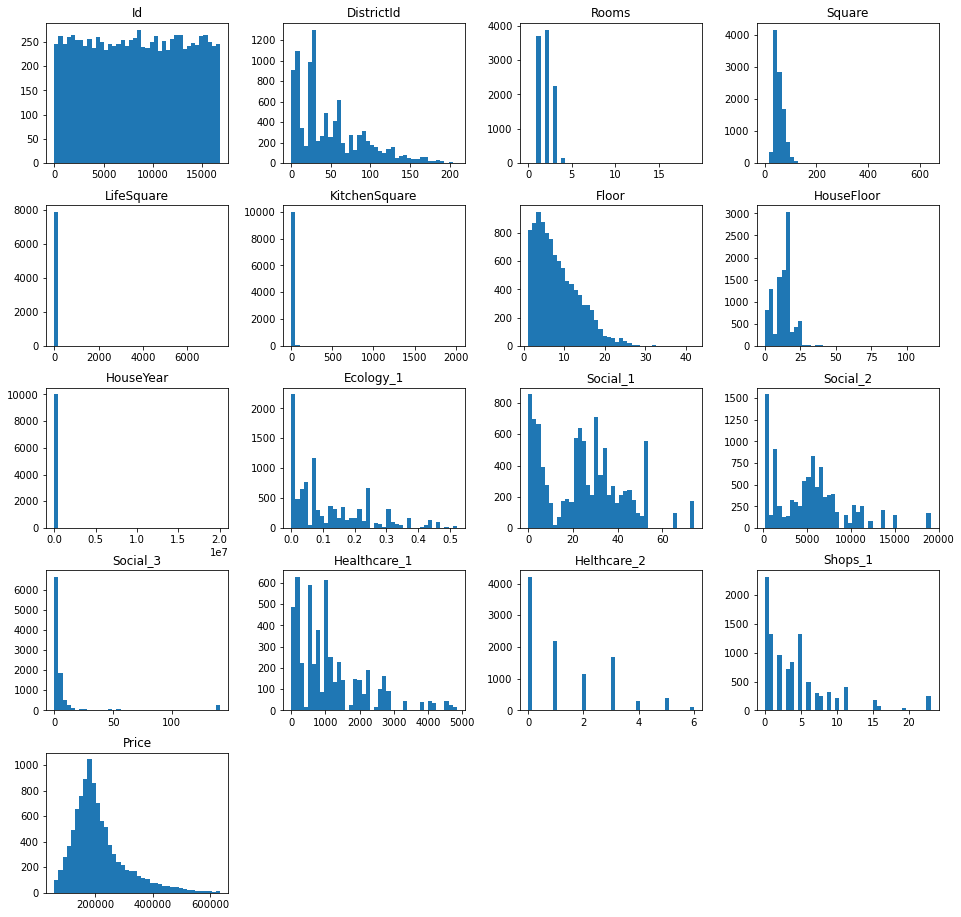

In [7]:
train_df.hist(figsize=(16,16), bins=40, grid=False);

In [8]:
# Rooms: все, что более 10 или 0, заменяем на медиану:
train_df.loc[(train_df['Rooms'] >= 10) | (train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].median()
test_df.loc[(test_df['Rooms'] >= 10) | (test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].median()

# Square: все, что более 150, заменяем на максимальное значение ряда до 150:
train_df.loc[train_df['Square'] >= 150, 'Square'] = train_df.loc[train_df['Square'] < 150, 'Square'].max()
test_df.loc[test_df['Square'] >= 150, 'Square'] = train_df.loc[train_df['Square'] < 150, 'Square'].max()

# LifeSquare: все, что более 150, заменяем на максимальное значение ряда до 150:
train_df.loc[train_df['LifeSquare'] >= 150, 'LifeSquare'] = train_df.loc[train_df['LifeSquare'] < 150, 'LifeSquare'].max()
test_df.loc[test_df['LifeSquare'] >= 150, 'LifeSquare'] = train_df.loc[train_df['LifeSquare'] < 150, 'LifeSquare'].max()

# KitchenSquare: все, что более 30, заменяем на максимальное значение ряда до 30:
train_df.loc[train_df['KitchenSquare'] >= 30, 'KitchenSquare'] = train_df.loc[train_df['KitchenSquare'] < 30, 'KitchenSquare'].max()
test_df.loc[test_df['KitchenSquare'] >= 30, 'KitchenSquare'] = train_df.loc[train_df['KitchenSquare'] < 30, 'KitchenSquare'].max()

train_df.loc[train_df['KitchenSquare'] == 0, 'KitchenSquare'] = train_df['KitchenSquare'].median()
test_df.loc[test_df['KitchenSquare'] == 0, 'KitchenSquare'] = train_df['KitchenSquare'].median()

# Добавляем новый признак Floor_cat - уровень этажа: 1, 2 или 3:
train_df['Floor_cat'] = 0
train_df.loc[train_df['Floor'] <= 4, 'Floor_cat'] = 1
train_df.loc[(train_df['Floor'] > 4) & (train_df['Floor'] <= 12), 'Floor_cat'] = 2
train_df.loc[(train_df['Floor'] > 12), 'Floor_cat'] = 3
# train_df['Floor_cat'].value_counts()
test_df['Floor_cat'] = 0
test_df.loc[test_df['Floor'] <= 4, 'Floor_cat'] = 1
test_df.loc[(test_df['Floor'] > 4) & (test_df['Floor'] <= 12), 'Floor_cat'] = 2
test_df.loc[(test_df['Floor'] > 12), 'Floor_cat'] = 3
# test_df['Floor_cat'].value_counts()

# HouseFloor: все, что более 40, заменяем на максимальное значение ряда до 40:
train_df.loc[train_df['HouseFloor'] >= 40, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] < 40, 'HouseFloor'].max()
test_df.loc[test_df['HouseFloor'] >= 40, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] < 40, 'HouseFloor'].max()
# 0 заменяем на медиану:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
test_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

# HouseYear: все, что старше 2021 - заменяем на максимальное значение ряда до 2021:
train_df.loc[train_df['HouseYear'] >= 2021, 'HouseYear'] = train_df.loc[train_df['HouseFloor'] < 2021, 'HouseFloor'].max()
test_df.loc[test_df['HouseYear'] >= 2021, 'HouseYear'] = train_df.loc[train_df['HouseFloor'] < 2021, 'HouseFloor'].max()
# Есть значения с количеством лет, чтобы высчитать год постройки отнимем от 2020 количество лет:
train_df.loc[train_df['HouseYear'] < 100, 'HouseYear'] = 2020 - train_df['HouseYear']
test_df.loc[test_df['HouseYear'] < 100, 'HouseYear'] = 2020 - test_df['HouseYear']

# Ecology_2 и Ecology_3 преобразуем в дамми-переменные:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2', prefix_sep='_')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_2'], prefix='Ecology_2', prefix_sep='_')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3', prefix_sep='_')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Ecology_2'], prefix='Ecology_3', prefix_sep='_')], axis=1)

# Social_3: все, что более 25, заменяем на максимальное значение ряда до 25:
train_df.loc[train_df['Social_3'] >= 25, 'Social_3'] = train_df.loc[train_df['Social_3'] < 25, 'Social_3'].max()
test_df.loc[test_df['Social_3'] >= 25, 'Social_3'] = train_df.loc[train_df['Social_3'] < 25, 'Social_3'].max()

# Shops_2 преобразуем в дамми-переменные:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2', prefix_sep='_')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Shops_2'], prefix='Shops_2', prefix_sep='_')], axis=1)

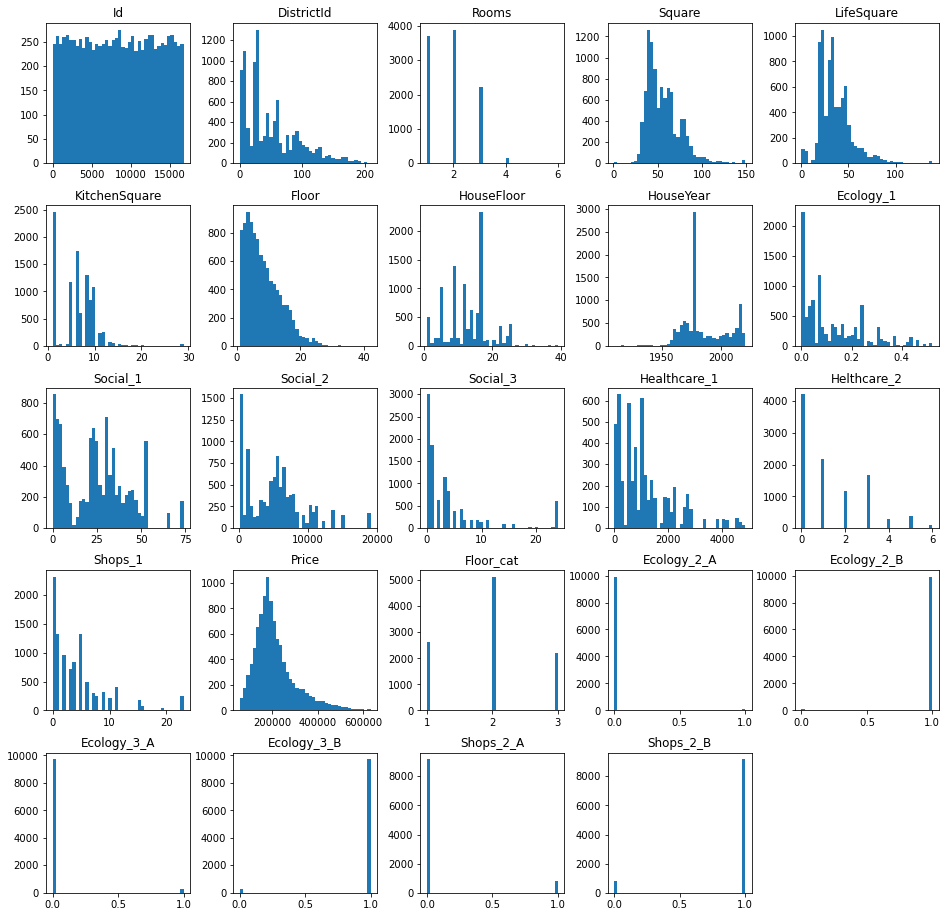

In [9]:
train_df.hist(figsize=(16,16), bins=40, grid=False);

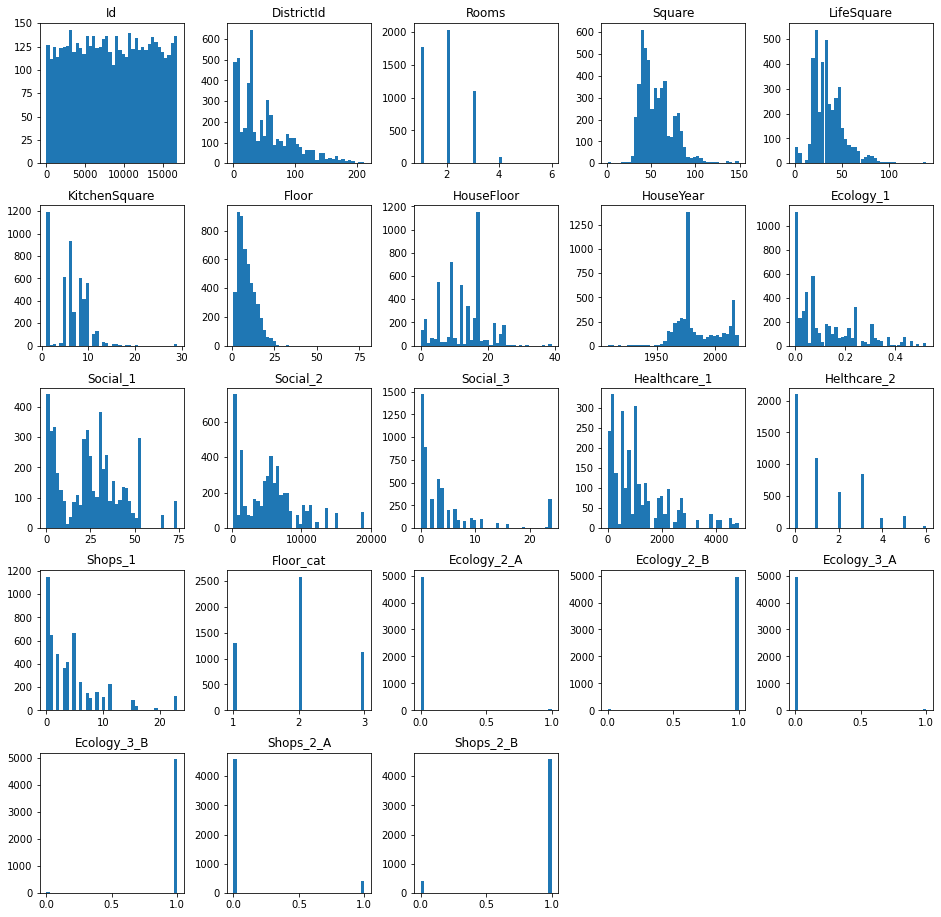

In [10]:
test_df.hist(figsize=(16,16), bins=40, grid=False);

**Корреляционная матрица:**

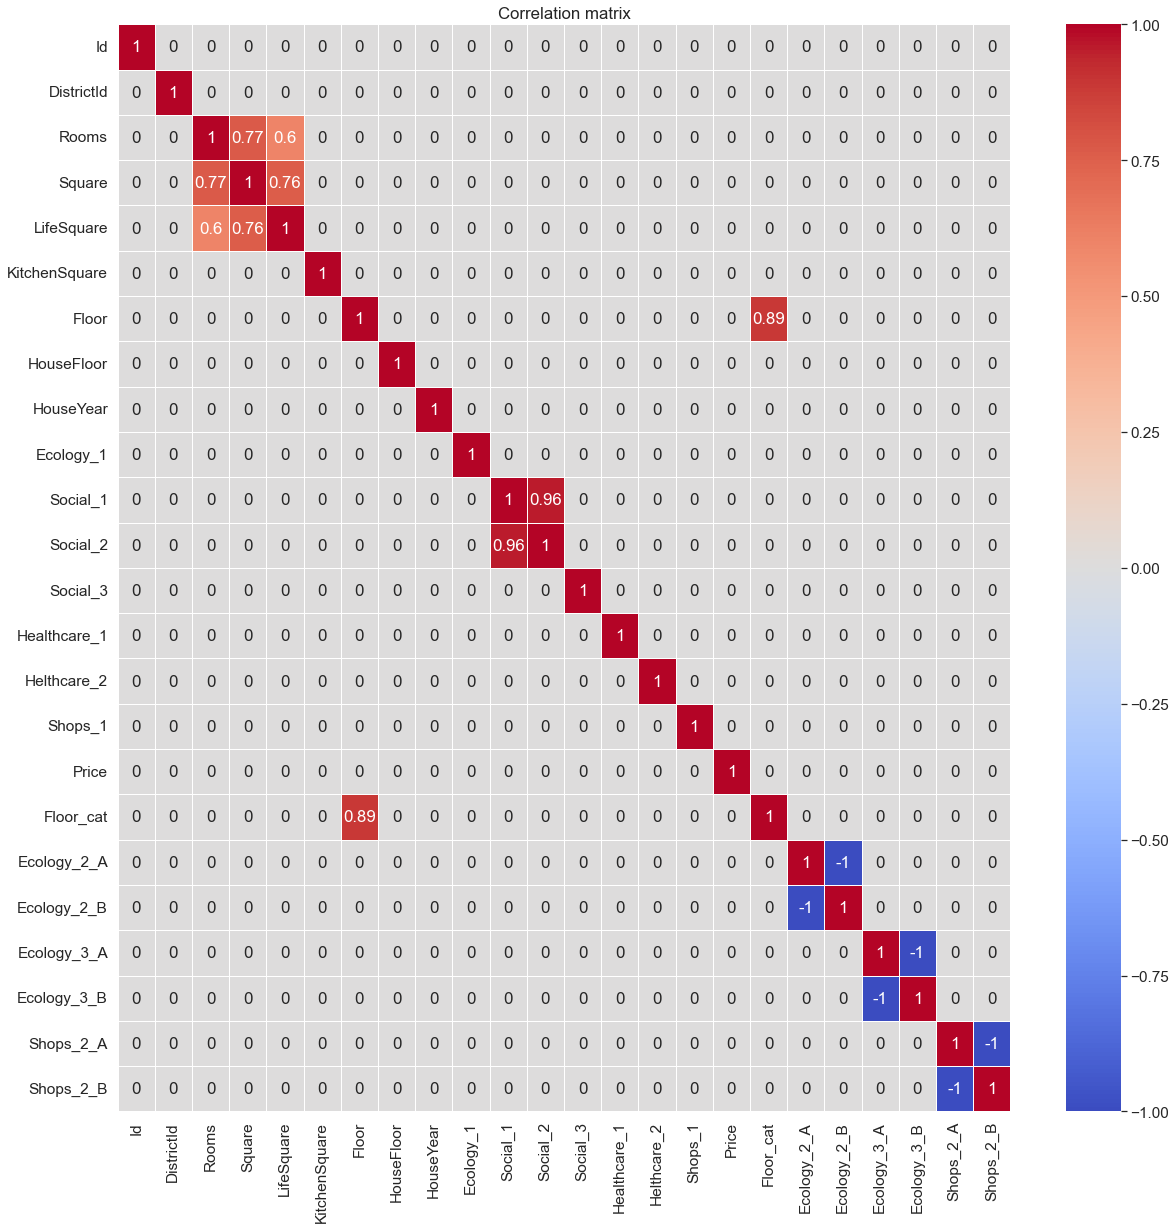

In [11]:
plt.figure(figsize = (20,20))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.6] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [12]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_cat,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,1,0,1,0,1,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,2,0,1,0,1,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,1,0,1,0,1,0,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,2,0,1,0,1,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,3,0,1,0,1,0,1
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138,2,0,1,0,1,0,1
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272,1,0,1,0,1,0,1
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191,2,0,1,0,1,0,1
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,2,0,1,0,1,0,1
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945,1,0,1,0,1,0,1


In [13]:
# Удалим признаки object:
train_df = train_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
test_df = test_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

**Спрогнозируем пропущенные значения Healthcare_1 для трейна:**

In [14]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

Train R2:	1.0
Test R2:	0.995


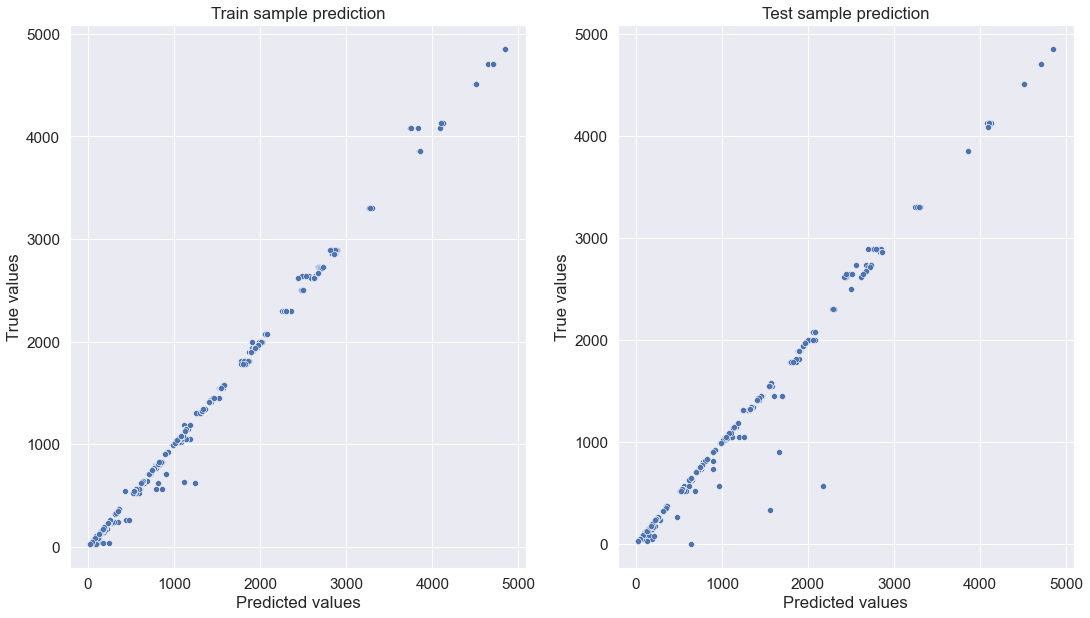

In [15]:
# сделаем столбец 0 с индексами, по которым потом соберем обратно:
train_df['0'] = [x for x in range(len(train_df))]

# удалим столбцы, которые не нужны для предсказания Healthcare_1, но запишем из предварительно в другой массив:
df_drop = train_df[['LifeSquare', '0']]
train_df.drop(['LifeSquare'], axis=1, inplace=True)

# разделим на трейн (0) и тест (1) в зависимости от заполненности значения:
target_name = 'Healthcare_1'
train_df['nan'] = 0
train_df.loc[train_df[target_name].isna(), 'nan'] = 1
df_train = train_df[train_df['nan'] == 0]
df_test = train_df[train_df['nan'] == 1]

# сформируем Х и у:
df_train = df_train.drop(columns='nan')
X = df_train.drop(columns=[target_name, '0'])
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [16]:
# удалим ненужные столбцы на тесте для дальнейшего прогноза:
v = [x for x in df_test['0']]
df_test = df_test.drop(columns=[target_name, '0'])
df_test = df_test.drop(columns='nan')

# предскажем значение Healthcare_1:
df_test[target_name] = rf_model.predict(df_test)
df_test[target_name] = df_test[target_name].apply(int)

# соединим обратно все в train_df2:
df_test['0'] = v
train_df2 = pd.concat([df_train, df_test])
train_df2 = train_df2.sort_values(by=['0'])
train_df2 = train_df2.merge(df_drop, left_on='0', right_on='0', how='left')
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Healthcare_1   10000 non-null  float64
 13  Helthcare_2    10000 non-null  int64  
 14  Shops_1        10000 non-null  int64  
 15  Price          10000 non-null  float64
 16  Floor_cat      10000 non-null  int64  
 17  Ecology_2_A    10000 non-null  uint8  
 18  Ecology

**Спрогнозируем пропущенные значения LifeSquare:** 

Train R2:	0.95
Test R2:	0.636


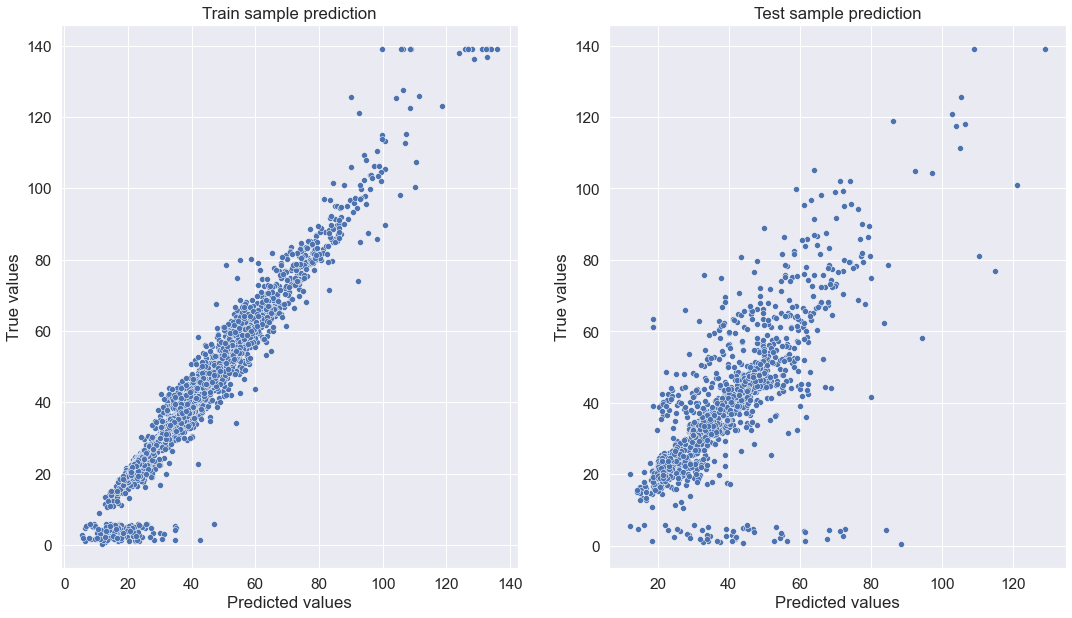

In [17]:
# разделим на трейн (0) и тест (1) в зависимости от заполненности значения:
target_name = 'LifeSquare'
train_df2['nan'] = 0
train_df2.loc[train_df2[target_name].isna(), 'nan'] = 1
df_train = train_df2[train_df2['nan'] == 0]
df_test = train_df2[train_df2['nan'] == 1]

# сформируем Х и у:
df_train = df_train.drop(columns='nan')
X = df_train.drop(columns=[target_name, '0'])
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [18]:
# удалим ненужные столбцы на тесте для дальнейшего прогноза:
v = [x for x in df_test['0']]
df_test = df_test.drop(columns=[target_name, '0'])
df_test = df_test.drop(columns='nan')

# предскажем значение LifeSquare:
df_test[target_name] = rf_model.predict(df_test)
df_test[target_name] = df_test[target_name].apply(int)

# соединим обратно все в train_df2:
df_test['0'] = v
train_df2 = pd.concat([df_train, df_test])
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 9991
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Healthcare_1   10000 non-null  float64
 13  Helthcare_2    10000 non-null  int64  
 14  Shops_1        10000 non-null  int64  
 15  Price          10000 non-null  float64
 16  Floor_cat      10000 non-null  int64  
 17  Ecology_2_A    10000 non-null  uint8  
 18  Ecology

**Повторим для теста:**

Спрогнозируем пропущенные значения Healthcare_1 для теста:

Train R2:	0.999
Test R2:	0.991


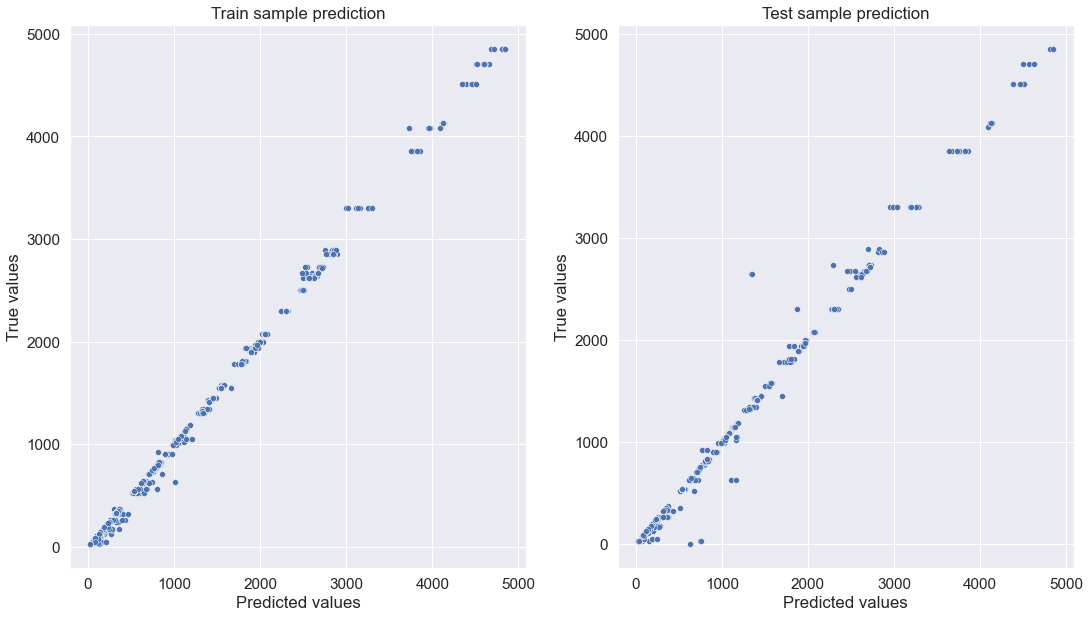

In [19]:
# сделаем столбец 0 с индексами, по которым потом соберем обратно:
test_df['0'] = [x for x in range(len(test_df))]

# удалим столбцы, которые не нужны для предсказания Healthcare_1, но запишем из предварительно в другой массив:
df_drop = test_df[['LifeSquare', '0']]
test_df.drop(['LifeSquare'], axis=1, inplace=True)

# разделим на трейн (0) и тест (1) в зависимости от заполненности значения:
target_name = 'Healthcare_1'
test_df['nan'] = 0
test_df.loc[test_df[target_name].isna(), 'nan'] = 1
df_train = test_df[test_df['nan'] == 0]
df_test = test_df[test_df['nan'] == 1]

# сформируем Х и у:
df_train = df_train.drop(columns='nan')
X = df_train.drop(columns=[target_name, '0'])
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [20]:
# удалим ненужные столбцы на тесте для дальнейшего прогноза:
v = [x for x in df_test['0']]
df_test = df_test.drop(columns=[target_name, '0'])
df_test = df_test.drop(columns='nan')

# предскажем значение Healthcare_1:
df_test[target_name] = rf_model.predict(df_test)
df_test[target_name] = df_test[target_name].apply(int)

# соединим обратно все в test_df2:
df_test['0'] = v
test_df2 = pd.concat([df_train, df_test])
test_df2 = test_df2.sort_values(by=['0'])
test_df2 = test_df2.merge(df_drop, left_on='0', right_on='0', how='left')
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Social_1       5000 non-null   int64  
 10  Social_2       5000 non-null   int64  
 11  Social_3       5000 non-null   int64  
 12  Healthcare_1   5000 non-null   float64
 13  Helthcare_2    5000 non-null   int64  
 14  Shops_1        5000 non-null   int64  
 15  Floor_cat      5000 non-null   int64  
 16  Ecology_2_A    5000 non-null   uint8  
 17  Ecology_2_B    5000 non-null   uint8  
 18  Ecology_

Спрогнозируем пропущенные значения LifeSquare для теста:

Train R2:	0.942
Test R2:	0.581


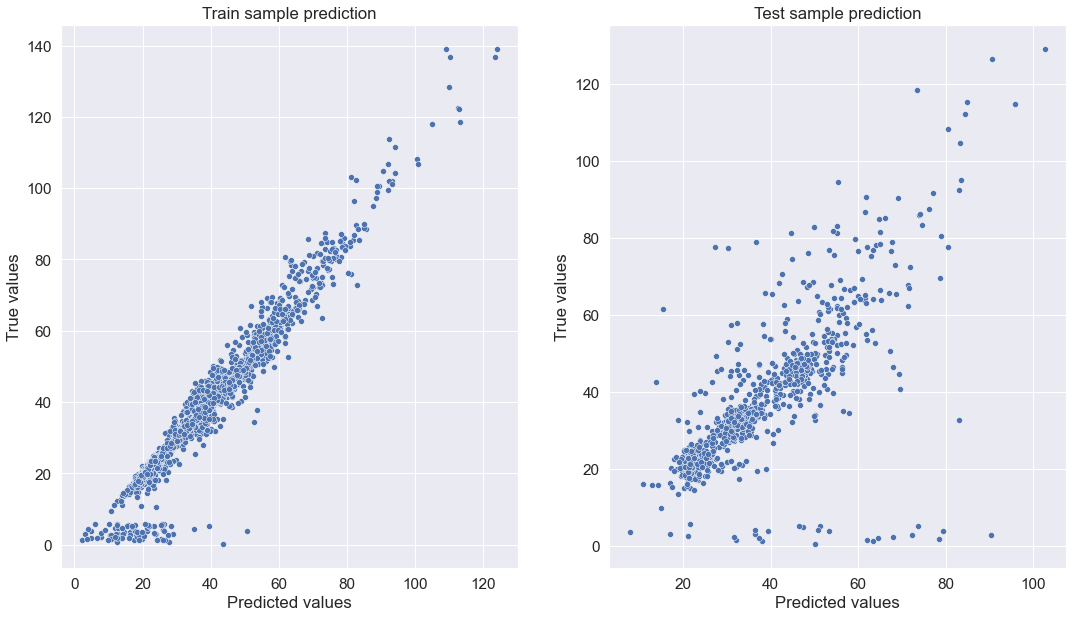

In [21]:
# разделим на трейн (0) и тест (1) в зависимости от заполненности значения:
target_name = 'LifeSquare'
test_df2['nan'] = 0
test_df2.loc[test_df2[target_name].isna(), 'nan'] = 1
df_train = test_df2[test_df2['nan'] == 0]
df_test = test_df2[test_df2['nan'] == 1]

# сформируем Х и у:
df_train = df_train.drop(columns='nan')
X = df_train.drop(columns=[target_name, '0'])
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [22]:
# удалим ненужные столбцы на тесте для дальнейшего прогноза:
v = [x for x in df_test['0']]
df_test = df_test.drop(columns=[target_name, '0'])
df_test = df_test.drop(columns='nan')

# предскажем значение LifeSquare:
df_test[target_name] = rf_model.predict(df_test)
df_test[target_name] = df_test[target_name].apply(int)

# соединим обратно все в test_df2:
df_test['0'] = v
test_df2 = pd.concat([df_train, df_test])
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4993
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Social_1       5000 non-null   int64  
 10  Social_2       5000 non-null   int64  
 11  Social_3       5000 non-null   int64  
 12  Healthcare_1   5000 non-null   float64
 13  Helthcare_2    5000 non-null   int64  
 14  Shops_1        5000 non-null   int64  
 15  Floor_cat      5000 non-null   int64  
 16  Ecology_2_A    5000 non-null   uint8  
 17  Ecology_2_B    5000 non-null   uint8  
 18  Ecology_

**Спрогнозируем Price:**

In [23]:
target_name = 'Price'
feachure_name = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Floor_cat', 'HouseFloor', 'HouseYear', 
                 'Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B',
                 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_A', 'Shops_2_B']
X = train_df2[feachure_name]
y = train_df2[target_name]

Train R2:	0.869
Test R2:	0.751


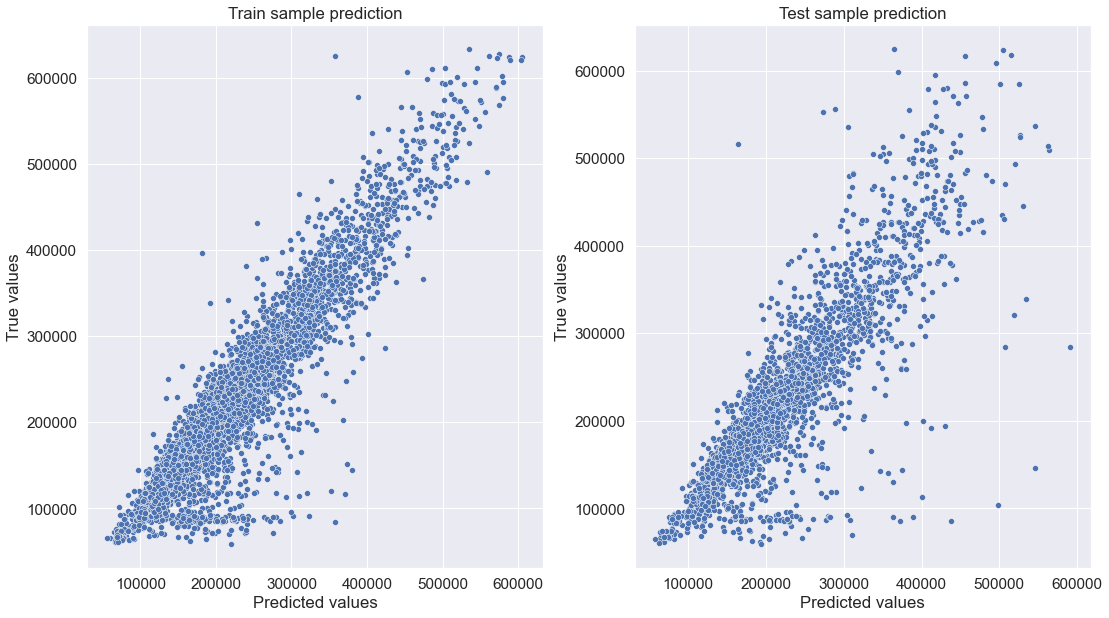

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     max_features=4,
                                     random_state=42,
                                     n_estimators=250)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Подбор параметров через GridSearchCV:

%%time
params = {'n_estimators': [250, 300, 350],
          'max_features': [4, 5],
          'max_depth': [3, 5, 7]}

gs = GridSearchCV(gb_model, params,
                  scoring='r2', # метрика
                  cv=KFold(n_splits=5, # k (Кол-во разбиений/итераций) в кросс-валидации
                           random_state=21,
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

gs.best_params_

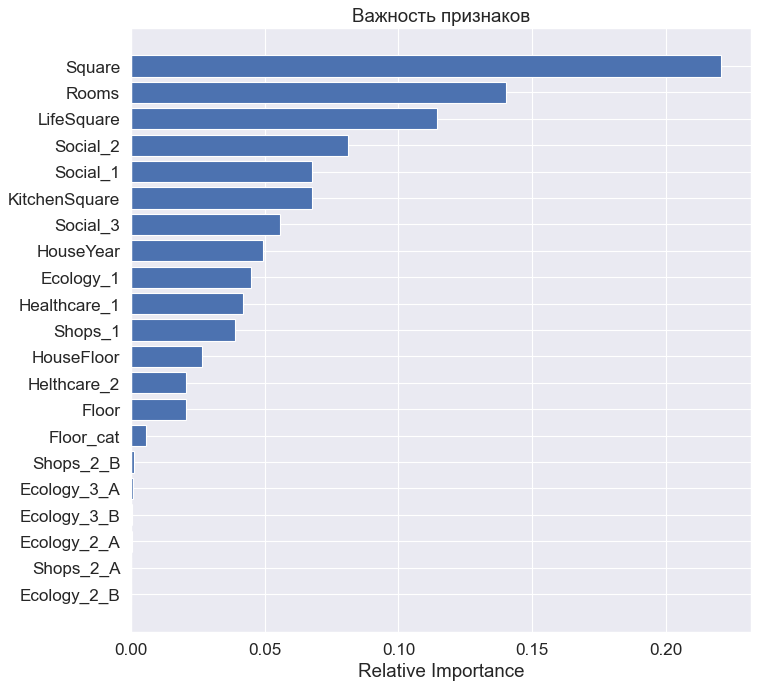

In [25]:
importances = gb_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10), dpi=80)
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
y_test = gb_model.predict(test_df2[feachure_name])
submit = pd.DataFrame({'Id': test_df2['Id'], 'Price': y_test})
submit.to_csv('gb_submit.csv', index=False)
submit.head(5)

,Id,Price
0,4567,162801.446376
1,5925,122554.097721
3,3848,133475.460269
5,868,309108.614112
6,672,114737.962115


<AxesSubplot:>

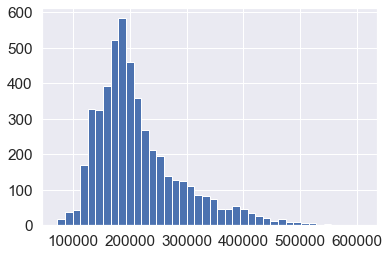

In [27]:
submit['Price'].hist(bins=40)

In [28]:
# Rusak Irina 0.72103